In [88]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv


In [54]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [55]:
train_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv')
print(train_data.shape[0])
train_data.head()

159571


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


__notebook_source__.ipynb


In [87]:
test_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv')
test_labels = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv')

FileNotFoundError: [Errno 2] File b'/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv' does not exist: b'/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv'

In [57]:
train_data_new = train_data[~(train_data['comment_text'].str.len() == 0)]
print(train_data_new.shape[0])

159571


In [58]:
# function for text cleaning 
def text_cleanup(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [59]:
train_data['comment_text_cleaned'] = train_data['comment_text'].apply(lambda x: text_cleanup(x))
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text_cleaned
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww he matches this background colour im seem...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man im really not trying to edit war its j...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i cant make any real suggestions on impro...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember wh...


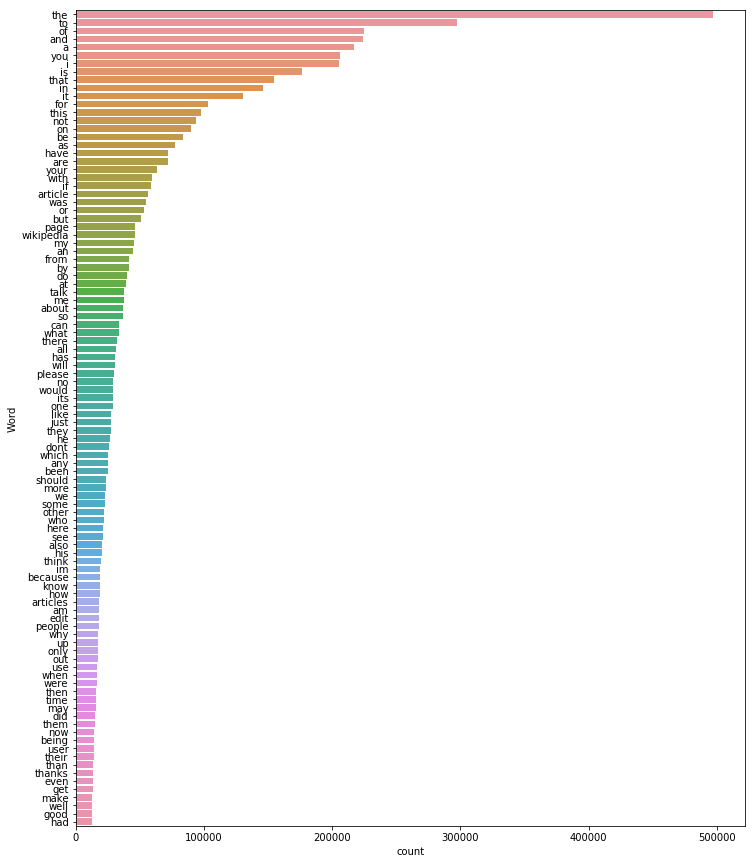

In [60]:
import seaborn as sns
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(train_data['comment_text_cleaned'], 100)

In [61]:
#now we need to remove stop words
nltk.download('stopwords')


[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [62]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

train_data['comment_text_cleaned'] = train_data['comment_text_cleaned'].apply(lambda x: remove_stopwords(x))


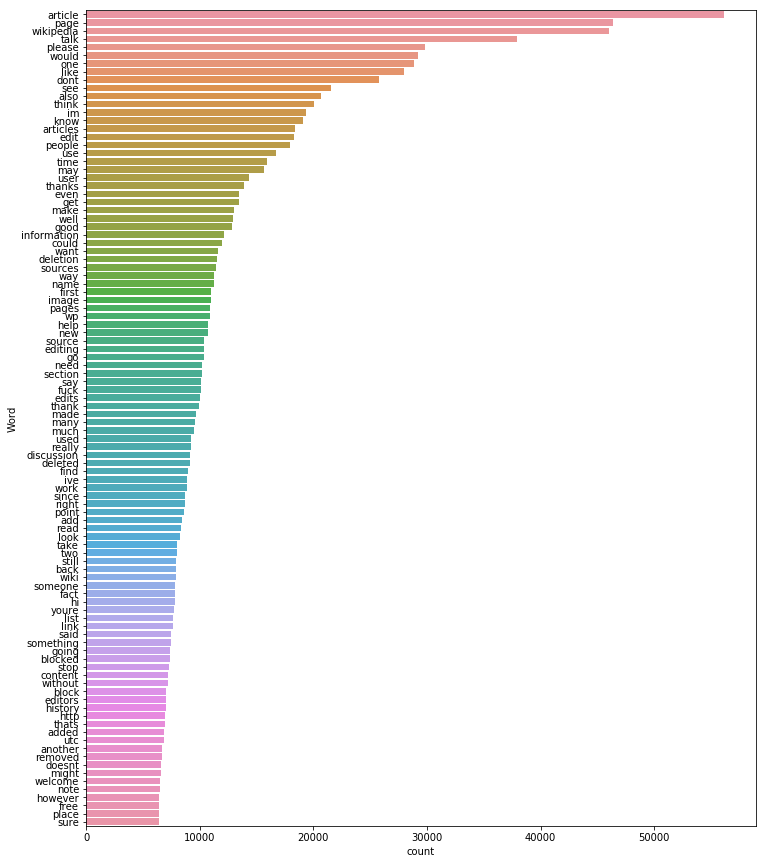

In [63]:
freq_words(train_data['comment_text_cleaned'], 100)

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

In [65]:
xtrain = train_data['comment_text_cleaned']
ytrain = train_data[train_data.columns[2:7]] 
# xtrain.head()
ytrain.head()

,toxic,severe_toxic,obscene,threat,insult
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [66]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)

In [67]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [68]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [69]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [71]:
#we need to do the same operation on the test data 
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [86]:
test_data['comment_text_cleaned'] = test_data['comment_text'].apply(lambda x: text_cleanup(x))
test_data['comment_text_cleaned'] = test_data['comment_text_cleaned'].apply(lambda x: remove_stopwords(x))


In [81]:
xtest = test_data['comment_text_cleaned']
ytest = test_data[test_data.columns[2:7]]
# y_test = test.drop(labels = ['id','comment_text'], axis=1)

In [85]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [75]:
xtest_tfidf = tfidf_vectorizer.fit_transform(xtest)

In [76]:
# make predictions for validation set
y_pred = clf.predict(xtest_tfidf)

In [77]:
y_pred[3]

array([0, 0, 0, 0, 0])

In [90]:
y_pred_prob = clf.predict_proba(xtest_tfidf)

In [91]:
y_pred_prob

array([[0.086801, 0.004083, 0.014122, 0.001803, 0.017937],
       [0.056988, 0.005554, 0.018039, 0.002316, 0.016404],
       [0.044235, 0.005639, 0.017081, 0.00212 , 0.018102],
       [0.014256, 0.004359, 0.013761, 0.00176 , 0.012922],
       ...,
       [0.141277, 0.006679, 0.052408, 0.00237 , 0.022552],
       [0.058702, 0.006252, 0.025399, 0.002301, 0.043333],
       [0.0451  , 0.004422, 0.017292, 0.002114, 0.017577],
       [0.037503, 0.005008, 0.01869 , 0.001725, 0.018949]])

In [92]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [93]:
y_pred_new

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [96]:
labels = pd.DataFrame(y_pred_new)

In [109]:
type(labels)

pandas.core.frame.DataFrame

In [107]:
xtest= xtest.to_frame()

In [115]:
submission = pd.concat([xtest,labels], axis = 1)

In [116]:
submission.head()

,comment_text_cleaned,0,1,2,3,4
0,yo bitch ja rule succesful youll ever whats ha...,0,0,0,0,0
1,rfc title fine imo,0,0,0,0,0
2,sources zawe ashton lapland,0,0,0,0,0
3,look back source information updated correct f...,0,0,0,0,0
4,dont anonymously edit articles,0,0,0,0,0


In [119]:
submission.to_csv('submission.csv')

In [120]:
from IPython.display import FileLink
FileLink(r'doc.csv')

/kaggle/working/doc.csv